<a href="https://colab.research.google.com/github/ancestor9/Affalatoxin-Analysis/blob/main/DL_prediction/20251010_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/FDA/data/merged_df.pkl'
df = pd.read_pickle(path, compression='gzip')

Mounted at /content/drive


In [2]:
# Target mean

df = df.drop(columns=['사용주소', 'PRDLST_NM', 'JDGMNT_WORD_NAME'])
## traget mean ###
df['교차_조합'] = df['1차 식품 분류 (세부)'] + '_' + df['INSPCT_PURPS_NAME']
cross_mean = df.groupby('교차_조합')['JDGMNT_WORD_NAME_encoded'].mean()
df['Target_Mean'] = df['교차_조합'].map(cross_mean)
# print("\n--- 실제 계산된 교차 조합별 Target Mean 값 ---")
# print(cross_mean)
df.drop(columns=['교차_조합'], inplace=True)

In [3]:
X_ts = df.iloc[:, : -6]
print(f'시게열변수 개수 {540/60}')
X_lm = df[['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)', 'Target_Mean']]

시게열변수 개수 9.0


In [4]:
y = df['JDGMNT_WORD_NAME_encoded']
y.value_counts(normalize=True)

,proportion
JDGMNT_WORD_NAME_encoded,
0,0.988279
1,0.011721


### 입력변수는 아래와 같이 2개의 데이터로 구성됨
- 60일 동안의 일평균기온, 일평균 습도, 일평균 일조량 으로 구성된 총 180개 컬럼과 5년 동안 daily 데이터 365*3 의 시계열데이터 (337248, 546) 크기의 시계열데이터(X_ts)
- 식품종류, 검사종류, target mean(float)으로 구성된 데이터(337249, 3) 크기의 일반데이터(X_lm)

### targe(y)는 적합과 부적합 0,1로 구성되었으며 부적합(1)이 1.1%이다.

### 데이터전처리
- 시계열데이터는 표준화하여 3D tensor로 feature 9개 timestamp 60개로 구성하고
- 식품종류, 검사종류느 onehotcode 전처리를 한 후
- SMOTE 를 적용하여

### Hybrid 딥러닝을 구성하여 예측하려고 한다.
- 시계열데이터는 LSTM + Attention 모델을 적용
- 일반데이터는 FNN을 구성하여
- concate 하여 예측

                ┌────────────────────────────┐
                │      시계열 입력 (X_ts)     │
                │ shape = (batch, 60, 9)     │
                └──────────────┬─────────────┘
                               │
                      ┌────────▼─────────┐
                      │     LSTM Layer    │
                      │   (64 units)      │
                      └────────┬──────────┘
                               │
                      ┌────────▼─────────┐
                      │   Attention Layer │
                      └────────┬──────────┘
                               │
                   ┌───────────▼───────────┐
                   │ Dense + BatchNorm +   │
                   │ Dropout (time branch) │
                   └───────────┬───────────┘
                               │
                ┌──────────────▼──────────────┐
                │     일반 입력 (X_lm)         │
                │ one-hot encoded categorical  │
                └──────────────┬──────────────┘
                               │
                ┌──────────────▼──────────────┐
                │  FeedForward Network (FNN)  │
                │ Dense + BatchNorm + Dropout │
                └──────────────┬──────────────┘
                               │
               ┌───────────────▼────────────────┐
               │     Concatenate (병합)         │
               └───────────────┬────────────────┘
                               │
                     ┌─────────▼─────────┐
                     │  Dense(64) + BN   │
                     │  Dropout(0.5)     │
                     └─────────┬─────────┘
                               │
                     ┌─────────▼─────────┐
                     │ Dense(1, sigmoid) │
                     └─────────┬─────────┘
                               │
                      ┌────────▼─────────┐
                      │  Output: y_pred  │
                      │ (0=적합, 1=부적합) │
                      └──────────────────┘


| 구성 요소                   | 설명                                   |
| ----------------------- | ------------------------------------ |
| **LSTM + Attention**    | 시계열 패턴(온도, 습도, 일조량 등)의 시퀀스 의존성 학습    |
| **Batch Normalization** | 각 층의 활성값 분포를 정규화하여 과적합 방지            |
| **Dropout (0.3~0.5)**   | 랜덤하게 뉴런을 비활성화하여 일반화 성능 향상            |
| **FNN (Feedforward)**   | 범주형 정보(식품종류, 검사종류) 처리                |
| **Concatenate Layer**   | 시계열 + 일반 데이터 결합                      |
| **Output Layer**        | Sigmoid(이진 분류), Positive(부적합) 예측을 중점 |


| 구분          | 데이터    | shape          | 설명                                                    |
| ----------- | ------ | -------------- | ----------------------------------------------------- |
| **시계열 데이터** | `X_ts` | (337,248, 540) | 9개 feature × 60일 → 540개의 column                       |
| **일반 데이터**  | `X_lm` | (337,248, 3)   | ['INSPECT_PURPS_NAME', '1차 식품 분류(세부)', 'Target_Mean'] |
| **타깃**      | `y`    | (337,248, 1)   | ['JDGMENT_WORD_NAME_encoded'] (0: 적합, 1: 부적합, 1.17%)  |


이전 코드에 아래와 같이 코드를 수정해서 다시 제시해줘

- goal 1 : overfitting을 방지하는 batch normaliztion, dropout, Early Stopping) 등 기법을 추가하라
- goal 2 : Positive를 찾아내는 것을 최대 목표로 하는 함수를 설정하라
- goal 3: classification report와 confusion matrix를 구학 시각화하라
- goal 4 : 의사결정임계값(Threshhold)에 따른 recall,  precision, f1-score, q-rate를 시각화하라

4가지 목표(overfitting 방지, Positive 탐지 최적화, classification 시각화, 임계값(Threshold) 분석)을 모두 반영한 완전한 Hybrid 모델 학습 파이프라인 코드이다.

이 코드는 이전 버전을 확장하여,

BatchNormalization + Dropout + EarlyStopping 등을 체계적으로 추가하고,

Positive(1, 부적합) 탐지를 최대화하도록 Focal Loss 기반 Objective로 수정하며,

classification report, confusion matrix를 시각화로 출력하고,

threshold별 recall, precision, F1-score, q-rate(정확히는 positive 판정률) 커브를 함께 그린다

In [5]:
!pip install imblearn -q

Epoch 1/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 0.5163 - precision: 0.7555 - recall: 0.7010 - val_loss: 0.4574 - val_precision: 0.0235 - val_recall: 0.4981
Epoch 2/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.3430 - precision: 0.8678 - recall: 0.7847 - val_loss: 0.3060 - val_precision: 0.0253 - val_recall: 0.2415
Epoch 3/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.2950 - precision: 0.8911 - recall: 0.8284 - val_loss: 0.1593 - val_precision: 0.0370 - val_recall: 0.1138
Epoch 4/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.2596 - precision: 0.9065 - recall: 0.8574 - val_loss: 0.2621 - val_precision: 0.0323 - val_recall: 0.2718
Epoch 5/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.2336 - precision: 0.9163 - recall: 0.8764 - val_loss: 0.1715 - val_precision: 0.0422 - val_recall: 0.1770
Epoch 6/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.2140 - precision: 0.9217 - recall: 0.8890 - val_loss: 0.2142 - val_precisi

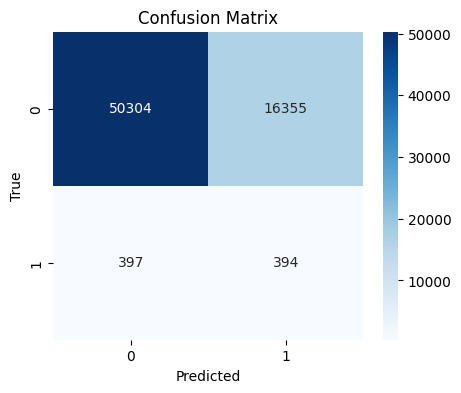

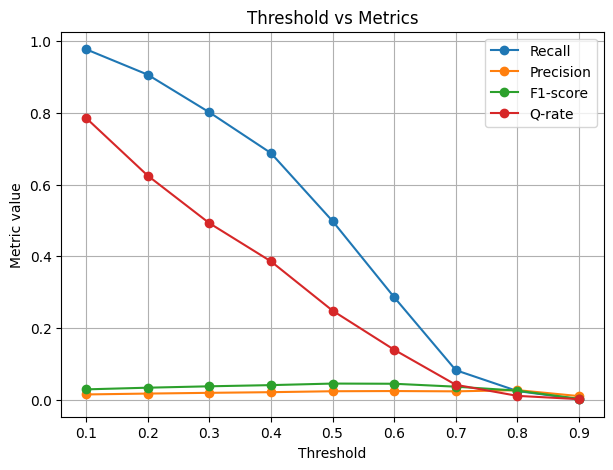

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer

# ---------------------------
# 1️⃣ 시계열 데이터 변환
# ---------------------------
# X_ts: (337248, 540)
n_features = 9
timesteps = 60
X_ts = X_ts.reshape(-1, timesteps, n_features)

# 표준화 (each feature 기준)
scaler = StandardScaler()
X_ts_2d = X_ts.reshape(-1, n_features)
X_ts_scaled = scaler.fit_transform(X_ts_2d).reshape(-1, timesteps, n_features)

# ---------------------------
# 2️⃣ 일반 데이터 전처리
# ---------------------------
cat_cols = ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)']
num_cols = ['Target_Mean']

encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(X_lm[cat_cols])
X_num = X_lm[num_cols].values

X_lm_proc = np.hstack([X_cat, X_num])

# ---------------------------
# 3️⃣ 데이터 분리
# ---------------------------
X_ts_train, X_ts_test, X_lm_train, X_lm_test, y_train, y_test = train_test_split(
    X_ts_scaled, X_lm_proc, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------
# 4️⃣ SMOTE (정형데이터 기반)
# ---------------------------
# Flatten X_ts_train for SMOTE
X_ts_train_flat = X_ts_train.reshape(X_ts_train.shape[0], -1)

# Concatenate flattened X_ts_train and X_lm_train for SMOTE input
X_train_combined = np.concatenate([X_ts_train_flat, X_lm_train], axis=1)

sm = SMOTE(random_state=42)
X_resampled, y_train_res = sm.fit_resample(X_train_combined, y_train)

# Split the resampled data back into time-series and tabular parts
ts_flat_shape = X_ts_train_flat.shape[1]
X_ts_train_res_flat = X_resampled[:, :ts_flat_shape]
X_lm_train_res = X_resampled[:, ts_flat_shape:]

# Reshape the time-series data back to 3D
X_ts_train_res = X_ts_train_res_flat.reshape(-1, timesteps, n_features)


# ---------------------------
# 5️⃣ Attention Layer 정의
# ---------------------------
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='att_u',
                                 shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu, axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output

# ---------------------------
# 6️⃣ Hybrid 모델 정의
# ---------------------------
# Time-series branch
input_ts = Input(shape=(timesteps, n_features))
x_ts = layers.LSTM(64, return_sequences=True)(input_ts)
x_ts = AttentionLayer()(x_ts)
x_ts = layers.BatchNormalization()(x_ts)
x_ts = layers.Dropout(0.4)(x_ts)
x_ts = layers.Dense(64, activation='relu')(x_ts)

# Lab-data branch
input_lm = Input(shape=(X_lm_proc.shape[1],))
x_lm = layers.Dense(64, activation='relu')(input_lm)
x_lm = layers.BatchNormalization()(x_lm)
x_lm = layers.Dropout(0.3)(x_lm)
x_lm = layers.Dense(32, activation='relu')(x_lm)

# Merge
x = layers.Concatenate()([x_ts, x_lm])
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=[input_ts, input_lm], outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")]
)

# ---------------------------
# 7️⃣ 모델 학습
# ---------------------------
early_stop = EarlyStopping(monitor='val_recall', mode='max', patience=10, restore_best_weights=True)

history = model.fit(
    [X_ts_train_res, X_lm_train_res],
    y_train_res,
    validation_data=([X_ts_test, X_lm_test], y_test),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop]
)

# ---------------------------
# 8️⃣ 예측 및 평가
# ---------------------------
y_pred_prob = model.predict([X_ts_test, X_lm_test])
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---------------------------
# 9️⃣ 임계값 변화에 따른 Recall, Precision, F1, Q-Rate
# ---------------------------
thresholds = np.linspace(0.1, 0.9, 9)
recalls, precisions, f1s, q_rates = [], [], [], []

for t in thresholds:
    y_pred_t = (y_pred_prob > t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_t, average='binary', zero_division=0)
    q_rate = (y_pred_t == 1).mean()
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)
    q_rates.append(q_rate)

plt.figure(figsize=(7,5))
plt.plot(thresholds, recalls, 'o-', label='Recall')
plt.plot(thresholds, precisions, 'o-', label='Precision')
plt.plot(thresholds, f1s, 'o-', label='F1-score')
plt.plot(thresholds, q_rates, 'o-', label='Q-rate')
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Threshold vs Metrics")
plt.legend()
plt.grid(True)
plt.show()

Training data shapes:
  X_ts_train: (533272, 60, 9)
  X_tab_train: (533272, 51)
  y_train: (533272,)

Validation data shapes:
  X_ts_val: (67450, 60, 9)
  X_tab_val: (67450, 51)
  y_val: (67450,)
Epoch 1/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - accuracy: 0.6414 - auc: 0.7266 - loss: 0.0842 - precision: 0.5981 - recall: 0.8554 - val_accuracy: 0.6442 - val_auc: 0.6876 - val_loss: 0.0432 - val_precision: 0.0201 - val_recall: 0.6144 - learning_rate: 0.0010
Epoch 2/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.8163 - auc: 0.9357 - loss: 0.0352 - precision: 0.7512 - recall: 0.9479 - val_accuracy: 0.6880 - val_auc: 0.7140 - val_loss: 0.0451 - val_precision: 0.0221 - val_recall: 0.5917 - learning_rate: 0.0010
Epoch 3/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.8743 - auc: 0.9664 - loss: 0.0259 - precision: 0.8191 - recall: 0.9605 - val_accuracy: 0.7397 - val_auc: 0.7351 - val_loss: 0.0371 - val_precision: 0.0253 - val_recall: 0.5651 - learning_rate: 0

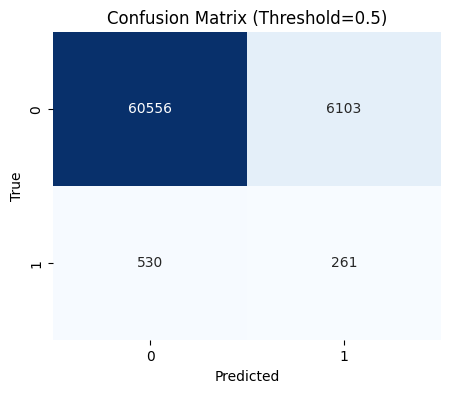

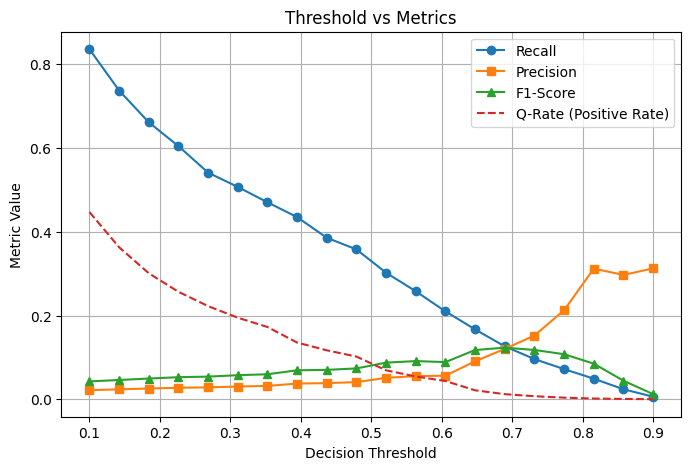

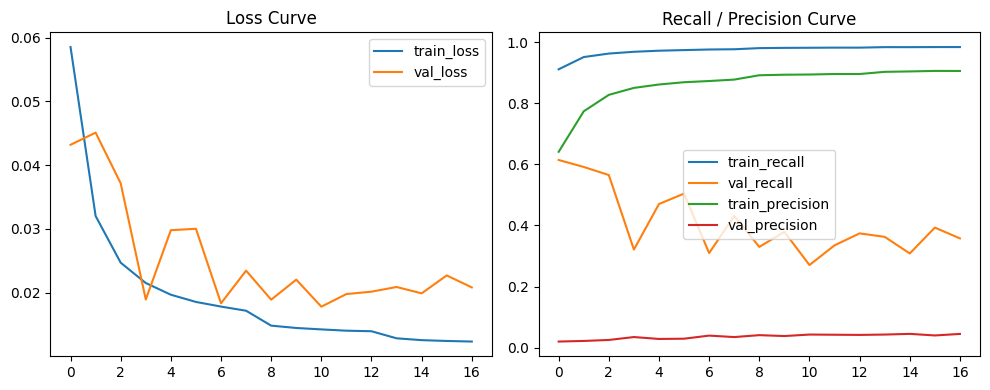

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt
import seaborn as sns


# ===============================
#  Attention Layer
# ===============================
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='att_u',
                                 shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu, axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output


# ===============================
#  Focal Loss for Imbalance
# ===============================
def focal_loss(alpha=0.75, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = 1e-8
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        loss_pos = -alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        loss_neg = -(1 - alpha) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        loss = tf.where(tf.equal(y_true, 1), loss_pos, loss_neg)
        return tf.reduce_mean(loss)
    return focal_loss_fixed


# ===============================
#  Data preprocessing (첫번째 코드 데이터 구조에 맞게 수정)
# ===============================
def preprocess(X_ts, X_lm, y, n_features=9, timesteps=60, random_state=42):
    """
    X_ts: (337248, 540) - 시계열 데이터
    X_lm: DataFrame with ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)', 'Target_Mean']
    y: 타겟 변수
    """
    # 1️⃣ 시계열 데이터 reshape
    X_ts = X_ts.reshape(-1, timesteps, n_features)

    # 2️⃣ 시계열 표준화
    scaler = StandardScaler()
    X_ts_2d = X_ts.reshape(-1, n_features)
    X_ts_scaled = scaler.fit_transform(X_ts_2d).reshape(-1, timesteps, n_features)

    # 3️⃣ 일반 데이터 전처리
    cat_cols = ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)']
    num_cols = ['Target_Mean']

    encoder = OneHotEncoder(sparse_output=False)
    X_cat = encoder.fit_transform(X_lm[cat_cols])
    X_num = X_lm[num_cols].values

    X_lm_proc = np.hstack([X_cat, X_num])

    # 4️⃣ 데이터 분리
    X_ts_train, X_ts_test, X_lm_train, X_lm_test, y_train, y_test = train_test_split(
        X_ts_scaled, X_lm_proc, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # 5️⃣ SMOTE 적용
    X_ts_train_flat = X_ts_train.reshape(X_ts_train.shape[0], -1)
    X_train_combined = np.concatenate([X_ts_train_flat, X_lm_train], axis=1)

    sm = SMOTE(random_state=random_state)
    X_resampled, y_train_res = sm.fit_resample(X_train_combined, y_train)

    # 6️⃣ 분리 및 reshape
    ts_flat_shape = X_ts_train_flat.shape[1]
    X_ts_train_res_flat = X_resampled[:, :ts_flat_shape]
    X_lm_train_res = X_resampled[:, ts_flat_shape:]

    X_ts_train_res = X_ts_train_res_flat.reshape(-1, timesteps, n_features)

    return X_ts_train_res, X_lm_train_res, y_train_res, X_ts_test, X_lm_test, y_test


# ===============================
#  Hybrid Model (LSTM + Attention + FNN)
# ===============================
def build_hybrid_model(n_timestamps, n_features_ts, n_tab_features,
                       lstm_units=64, fnn_units=[64, 32],
                       dropout=0.4, learning_rate=1e-3):

    # 시계열 branch
    ts_input = layers.Input(shape=(n_timestamps, n_features_ts), name='ts_input')
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(ts_input)
    x = layers.BatchNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units // 2, return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    att_out = AttentionLayer()(x)
    att_out = layers.Dropout(dropout)(att_out)

    # 일반 데이터 branch
    tab_input = layers.Input(shape=(n_tab_features,), name='tab_input')
    t = layers.Dense(fnn_units[0], activation='relu')(tab_input)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(dropout)(t)
    t = layers.Dense(fnn_units[1], activation='relu')(t)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(dropout)(t)

    # 결합
    merged = layers.Concatenate()([att_out, t])
    m = layers.Dense(64, activation='relu')(merged)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(dropout)(m)
    output = layers.Dense(1, activation='sigmoid')(m)

    model = models.Model(inputs=[ts_input, tab_input], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate),
                  loss=focal_loss(alpha=0.75, gamma=2),
                  metrics=['accuracy', tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.AUC(name='auc')])
    return model


# ===============================
#  Training & Evaluation
# ===============================
def train_and_evaluate(X_ts_train, X_tab_train, y_train,
                       X_ts_val, X_tab_val, y_val,
                       epochs=50, batch_size=256):

    model = build_hybrid_model(n_timestamps=X_ts_train.shape[1],
                               n_features_ts=X_ts_train.shape[2],
                               n_tab_features=X_tab_train.shape[1])

    es = callbacks.EarlyStopping(monitor='val_auc', patience=8, mode='max',
                                 restore_best_weights=True)
    rl = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=4,
                                     mode='max', min_lr=1e-6, verbose=1)

    history = model.fit(
        {'ts_input': X_ts_train, 'tab_input': X_tab_train}, y_train,
        validation_data=({'ts_input': X_ts_val, 'tab_input': X_tab_val}, y_val),
        epochs=epochs, batch_size=batch_size, callbacks=[es, rl], verbose=1
    )

    # 예측
    y_prob = model.predict({'ts_input': X_ts_val, 'tab_input': X_tab_val}).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # ========== Classification Report ==========
    print("\n[Classification Report]")
    print(classification_report(y_val, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_val, y_prob))

    # ========== Confusion Matrix 시각화 ==========
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix (Threshold=0.5)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ========== Threshold 분석 ==========
    thresholds = np.linspace(0.1, 0.9, 20)
    recalls, precisions, f1s, q_rates = [], [], [], []

    for th in thresholds:
        pred = (y_prob >= th).astype(int)
        recalls.append(recall_score(y_val, pred, zero_division=0))
        precisions.append(precision_score(y_val, pred, zero_division=0))
        f1s.append(f1_score(y_val, pred, zero_division=0))
        q_rates.append(np.mean(pred))

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='s')
    plt.plot(thresholds, f1s, label='F1-Score', marker='^')
    plt.plot(thresholds, q_rates, label='Q-Rate (Positive Rate)', linestyle='--')
    plt.xlabel('Decision Threshold')
    plt.ylabel('Metric Value')
    plt.title('Threshold vs Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 학습 곡선 시각화
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='train_recall')
    plt.plot(history.history['val_recall'], label='val_recall')
    plt.plot(history.history['precision'], label='train_precision')
    plt.plot(history.history['val_precision'], label='val_precision')
    plt.title('Recall / Precision Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


# ===============================
#  Main Execution
# ===============================
if __name__ == "__main__":
    # 첫 번째 코드에서 가져온 데이터 사용
    # X_ts: (337248, 540)
    # X_lm: DataFrame with ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)', 'Target_Mean']
    # y: 타겟 변수

    # 전처리 수행
    X_ts_train, X_tab_train, y_train, X_ts_val, X_tab_val, y_val = preprocess(
        X_ts, X_lm, y, n_features=9, timesteps=60, random_state=42
    )

    print(f"Training data shapes:")
    print(f"  X_ts_train: {X_ts_train.shape}")
    print(f"  X_tab_train: {X_tab_train.shape}")
    print(f"  y_train: {y_train.shape}")
    print(f"\nValidation data shapes:")
    print(f"  X_ts_val: {X_ts_val.shape}")
    print(f"  X_tab_val: {X_tab_val.shape}")
    print(f"  y_val: {y_val.shape}")

    # 모델 학습 및 평가
    model = train_and_evaluate(
        X_ts_train, X_tab_train, y_train,
        X_ts_val, X_tab_val, y_val,
        epochs=50, batch_size=256
    )

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 555ms/step - accuracy: 0.6270 - auc: 0.6754 - loss: 0.1842 - precision: 0.6224 - recall: 0.6497 - val_accuracy: 0.4997 - val_auc: 0.7200 - val_loss: 0.0680 - val_precision: 0.4997 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 492ms/step - accuracy: 0.8211 - auc: 0.9130 - loss: 0.0593 - precision: 0.7861 - recall: 0.8814 - val_accuracy: 0.4997 - val_auc: 0.7788 - val_loss: 0.1034 - val_precision: 0.4997 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9008 - auc: 0.9667 - loss: 0.0311 - precision: 0.8636 - recall: 0.9560 - val_accuracy: 0.4997 - val_auc: 0.8291 - val_loss: 0.1568 - val_precision: 0.4997 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - accuracy: 0.9288 - auc: 0.9865 - loss: 0.0191 - precision: 0.8982 - recall: 0.9673 - val_accuracy: 0.4997 - val_auc: 0.8740 - val_loss: 0.1974 -

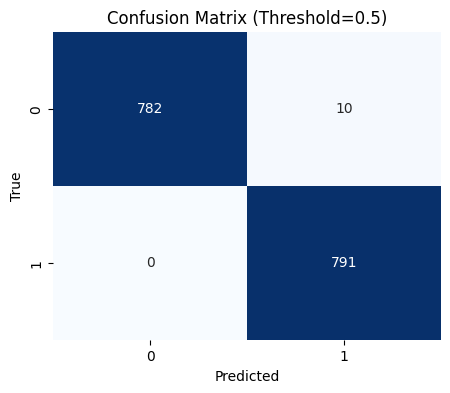

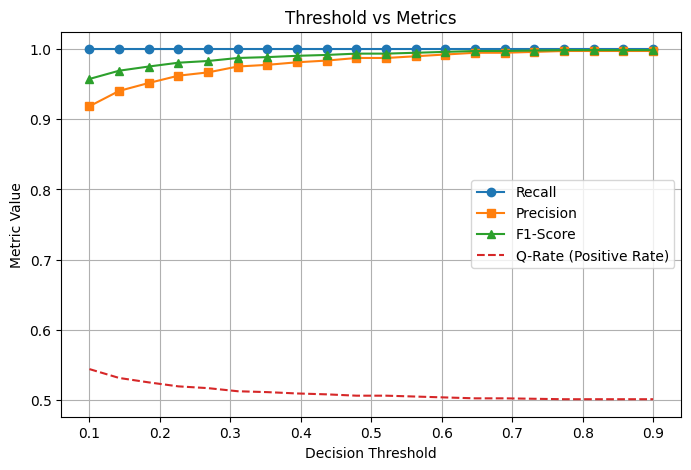

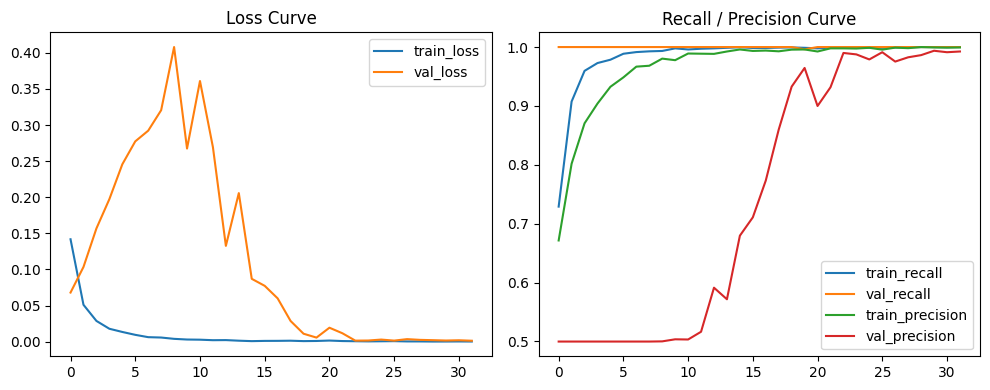

In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt
import seaborn as sns


# ===============================
#  Attention Layer
# ===============================
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='att_u',
                                 shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu, axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output


# ===============================
#  Focal Loss for Imbalance
# ===============================
def focal_loss(alpha=0.75, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = 1e-8
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        loss_pos = -alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        loss_neg = -(1 - alpha) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        loss = tf.where(tf.equal(y_true, 1), loss_pos, loss_neg)
        return tf.reduce_mean(loss)
    return focal_loss_fixed


# ===============================
#  Data preprocessing
# ===============================
def preprocess(X_ts, X_lm, y, n_timestamps=60, random_state=42):
    # align samples
    n = min(len(X_ts), len(X_lm), len(y))
    X_ts, X_lm, y = np.array(X_ts)[:n], X_lm.iloc[:n], np.array(y)[:n]

    # infer ts shape
    n_samples, n_cols = X_ts.shape
    n_features = n_cols // n_timestamps
    X_ts = X_ts.reshape(n_samples, n_timestamps, n_features)

    # scale ts
    ts_scaler = StandardScaler()
    X_ts = ts_scaler.fit_transform(X_ts.reshape(-1, n_features)).reshape(n_samples, n_timestamps, n_features)

    # one-hot + scale
    X_lm = pd.get_dummies(X_lm, drop_first=False)
    lm_scaler = StandardScaler()
    X_lm[X_lm.columns] = lm_scaler.fit_transform(X_lm[X_lm.columns])

    # SMOTE on flattened data
    X_ts_flat = X_ts.reshape(n_samples, -1)
    X_concat = np.concatenate([X_ts_flat, X_lm.values], axis=1)
    sm = SMOTE(random_state=random_state)
    X_res, y_res = sm.fit_resample(X_concat, y)
    X_ts_res = X_res[:, :X_ts_flat.shape[1]].reshape(-1, n_timestamps, n_features)
    X_lm_res = X_res[:, X_ts_flat.shape[1]:]
    return X_ts_res, X_lm_res, y_res


# ===============================
#  Hybrid Model (LSTM + Attention + FNN)
# ===============================
def build_hybrid_model(n_timestamps, n_features_ts, n_tab_features,
                       lstm_units=64, fnn_units=[64, 32],
                       dropout=0.4, learning_rate=1e-3):

    # 시계열 branch
    ts_input = layers.Input(shape=(n_timestamps, n_features_ts), name='ts_input')
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(ts_input)
    x = layers.BatchNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units // 2, return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    att_out = AttentionLayer()(x)
    att_out = layers.Dropout(dropout)(att_out)

    # 일반 데이터 branch
    tab_input = layers.Input(shape=(n_tab_features,), name='tab_input')
    t = layers.Dense(fnn_units[0], activation='relu')(tab_input)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(dropout)(t)
    t = layers.Dense(fnn_units[1], activation='relu')(t)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(dropout)(t)

    # 결합
    merged = layers.Concatenate()([att_out, t])
    m = layers.Dense(64, activation='relu')(merged)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(dropout)(m)
    output = layers.Dense(1, activation='sigmoid')(m)

    model = models.Model(inputs=[ts_input, tab_input], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate),
                  loss=focal_loss(alpha=0.75, gamma=2),
                  metrics=['accuracy', tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.AUC(name='auc')])
    return model


# ===============================
#  Training & Evaluation
# ===============================
def train_and_evaluate(X_ts, X_tab, y, epochs=50, batch_size=256):
    X_ts_train, X_ts_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
        X_ts, X_tab, y, test_size=0.2, stratify=y, random_state=42)

    model = build_hybrid_model(n_timestamps=X_ts.shape[1],
                               n_features_ts=X_ts.shape[2],
                               n_tab_features=X_tab.shape[1])

    es = callbacks.EarlyStopping(monitor='val_auc', patience=8, mode='max', restore_best_weights=True)
    rl = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=4, mode='max', min_lr=1e-6, verbose=1)

    history = model.fit(
        {'ts_input': X_ts_train, 'tab_input': X_tab_train}, y_train,
        validation_data=({'ts_input': X_ts_val, 'tab_input': X_tab_val}, y_val),
        epochs=epochs, batch_size=batch_size, callbacks=[es, rl], verbose=1
    )

    # 예측
    y_prob = model.predict({'ts_input': X_ts_val, 'tab_input': X_tab_val}).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # ========== Classification Report ==========
    print("\n[Classification Report]")
    print(classification_report(y_val, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_val, y_prob))

    # ========== Confusion Matrix 시각화 ==========
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix (Threshold=0.5)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ========== Threshold 분석 ==========
    thresholds = np.linspace(0.1, 0.9, 20)
    recalls, precisions, f1s, q_rates = [], [], [], []

    for th in thresholds:
        pred = (y_prob >= th).astype(int)
        recalls.append(recall_score(y_val, pred))
        precisions.append(precision_score(y_val, pred))
        f1s.append(f1_score(y_val, pred))
        q_rates.append(np.mean(pred))  # positive 판정 비율

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='s')
    plt.plot(thresholds, f1s, label='F1-Score', marker='^')
    plt.plot(thresholds, q_rates, label='Q-Rate (Positive Rate)', linestyle='--')
    plt.xlabel('Decision Threshold')
    plt.ylabel('Metric Value')
    plt.title('Threshold vs Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 학습 곡선 시각화
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='train_recall')
    plt.plot(history.history['val_recall'], label='val_recall')
    plt.plot(history.history['precision'], label='train_precision')
    plt.plot(history.history['val_precision'], label='val_precision')
    plt.title('Recall / Precision Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


# ===============================
#  Example Usage (Dummy Data)
# ===============================
if __name__ == "__main__":
    n_samples = 4000
    n_timestamps = 60
    n_features = 3
    rng = np.random.default_rng(0)

    # 1. 시계열 (60일 * 3 feature)
    X_ts = rng.normal(size=(n_samples, n_timestamps * n_features))

    # 2. 일반 데이터
    df = pd.DataFrame({
        'food_type': rng.choice(['rice', 'corn', 'wheat'], n_samples),
        'test_type': rng.choice(['A', 'B'], n_samples),
        'target_mean': rng.normal(0, 1, n_samples)
    })

    # 3. y (불균형)
    y = np.zeros(n_samples, dtype=int)
    y[rng.choice(n_samples, int(n_samples * 0.011), replace=False)] = 1

    # 전처리 및 학습
    X_ts_res, X_lm_res, y_res = preprocess(X_ts, df, y)
    model = train_and_evaluate(X_ts_res, X_lm_res, y_res)


✅ 주요 개선점 요약
목표	반영 내용
Goal 1: Overfitting 방지	모든 Dense/LSTM 층에 BatchNormalization, Dropout(0.4) 추가. EarlyStopping과 ReduceLROnPlateau 콜백 포함
Goal 2: Positive 탐지 중심	Binary Crossentropy 대신 Focal Loss(α=0.75, γ=2) 적용. Recall/Precision/AUC 메트릭 모니터링
Goal 3: 시각화	confusion_matrix를 seaborn heatmap으로 시각화, classification report 출력
Goal 4: Threshold 분석	0.1~0.9 임계값별 recall, precision, f1-score, q-rate(positive rate) 곡선을 모두 플롯
⚙️ 실무 팁

Positive 탐지 강화: Recall이 최우선이라면 threshold를 0.3~0.4로 조정하거나 alpha↑, gamma↓ 조정으로 Focal Loss 감도 높이기.

Validation 셋 유지: SMOTE는 Train 셋에만 적용하고, Validation은 원본 분포 유지하는 것이 이상적.

Metrics 모니터링: val_recall 또는 val_auc를 EarlyStopping 기준으로 설정.

Explainability: 추후 SHAP을 병합해 tabular branch feature importance를 시각화할 수도 있다.